### Modeling Setup 

Goal: Build and compare multiple classification models to predict track popularity levels based on key audio features.

Algorithms Implemented: 
- Decision Tree Classifier
- Random Forest Classifier  
- Logistic Regression  
- Bagging Classifier  

Evaluation Metrics:  
- Accuracy  
- Precision  
- Recall  
- F1 Score (macro)  
- Confusion Matrix  

Final Criteria: 
The best model was chosen based on a balance between predictive performance (F1 score), robustness to noise, generalization to test data, and scalability.  

In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer

In [236]:
X_train = pd.read_csv("X_train.csv", index_col=0)
X_test = pd.read_csv("X_test.csv", index_col=0)
y_train = pd.read_csv("y_train.csv").squeeze()
y_test = pd.read_csv("y_test.csv").squeeze()

In [271]:
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test[X_train.columns]

In [273]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed_array = imputer.fit_transform(X_train_numeric)
X_test_imputed_array = imputer.transform(X_test_numeric)

X_train_imputed = pd.DataFrame(X_train_imputed_array, columns=X_train_numeric.columns)
X_test_imputed = pd.DataFrame(X_test_imputed_array, columns=X_train_numeric.columns)

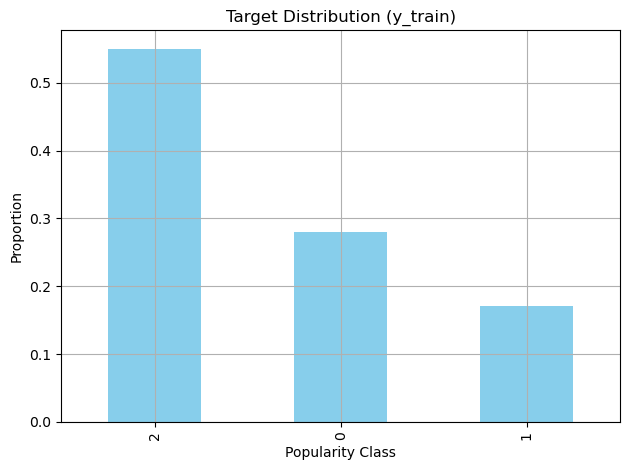

In [275]:
y_train.value_counts(normalize=True).plot(kind='bar', title='Target Distribution (y_train)', color='skyblue')
plt.xlabel("Popularity Class")
plt.ylabel("Proportion")
plt.grid(True)
plt.tight_layout()
plt.show()

In [277]:
# Decision Tree (GINI)
dt_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
dt_gini.fit(X_train, y_train)
y_pred_gini = dt_gini.predict(X_test)
print("\n Decision Tree (Gini):\n", classification_report(y_test, y_pred_gini))



 Decision Tree (Gini):
               precision    recall  f1-score   support

           0       0.84      0.80      0.82        88
           1       0.48      0.51      0.50        53
           2       0.78      0.79      0.79       172

    accuracy                           0.74       313
   macro avg       0.70      0.70      0.70       313
weighted avg       0.75      0.74      0.75       313



In [279]:
# Decision Tree (ENTROPY)
dt_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_entropy.fit(X_train, y_train)
y_pred_entropy = dt_entropy.predict(X_test)
print("\n Decision Tree (Entropy):\n", classification_report(y_test, y_pred_entropy))


 Decision Tree (Entropy):
               precision    recall  f1-score   support

           0       0.81      0.77      0.79        88
           1       0.53      0.49      0.51        53
           2       0.76      0.80      0.78       172

    accuracy                           0.74       313
   macro avg       0.70      0.69      0.69       313
weighted avg       0.74      0.74      0.74       313



In [281]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\n Random Forest:\n", classification_report(y_test, y_pred_rf))


 Random Forest:
               precision    recall  f1-score   support

           0       0.93      0.76      0.84        88
           1       0.72      0.34      0.46        53
           2       0.75      0.94      0.83       172

    accuracy                           0.79       313
   macro avg       0.80      0.68      0.71       313
weighted avg       0.79      0.79      0.77       313



In [283]:
# Bagging Classifier
bag = BaggingClassifier(random_state=42)
bag.fit(X_train, y_train)
y_pred_bag = bag.predict(X_test)
print("\n Bagging Classifier:\n", classification_report(y_test, y_pred_bag))


 Bagging Classifier:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84        88
           1       0.56      0.38      0.45        53
           2       0.76      0.84      0.80       172

    accuracy                           0.76       313
   macro avg       0.72      0.68      0.70       313
weighted avg       0.75      0.76      0.75       313



In [285]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_imputed, y_train)
y_pred_lr = lr.predict(X_test_imputed)
print("\n Logistic Regression:\n", classification_report(y_test, y_pred_lr))


 Logistic Regression:
               precision    recall  f1-score   support

           0       0.77      0.65      0.70        88
           1       0.53      0.17      0.26        53
           2       0.67      0.86      0.75       172

    accuracy                           0.68       313
   macro avg       0.66      0.56      0.57       313
weighted avg       0.67      0.68      0.65       313



In [287]:
# Hyperparamater Tuning (Random Forest)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train_imputed, y_train)
best_rf = grid.best_estimator_
y_pred_best = best_rf.predict(X_test_imputed)
print("\n Tuned Random Forest:\n", classification_report(y_test, y_pred_best))


 Tuned Random Forest:
               precision    recall  f1-score   support

           0       0.91      0.81      0.86        88
           1       0.67      0.34      0.45        53
           2       0.75      0.91      0.83       172

    accuracy                           0.79       313
   macro avg       0.78      0.69      0.71       313
weighted avg       0.78      0.79      0.77       313



In [289]:
# Model Comparision Table

models = {"DT Gini": dt_gini, "DT Entropy": dt_entropy, "Random Forest": rf, "Bagging": bag, "Logistic Regression": lr, "Tuned RF": best_rf}
cv_results = {name: {"F1 Macro": cross_val_score(model, X_train_imputed, y_train, cv=5, scoring='f1_macro').mean()} for name, model in models.items()}
cv_df = pd.DataFrame(cv_results).T.sort_values(by="F1 Macro", ascending=False)
print("\n Cross-Validation Results:\n", cv_df)



 Cross-Validation Results:
                      F1 Macro
Tuned RF             0.715193
Bagging              0.715167
Random Forest        0.702979
DT Gini              0.669170
DT Entropy           0.668360
Logistic Regression  0.543641


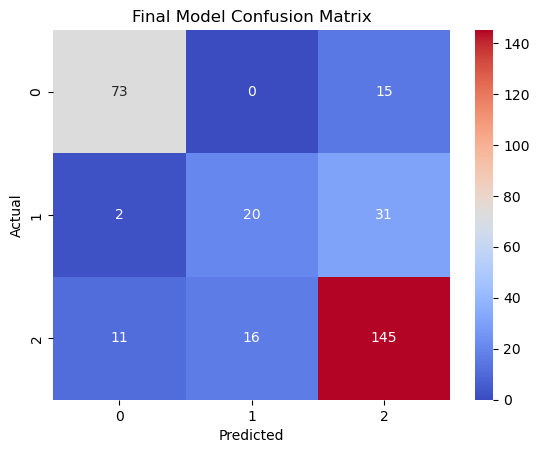

In [290]:
# Confusion Matrix
final_model = bag 
final_preds = final_model.predict(X_test_imputed)
sns.heatmap(confusion_matrix(y_test, final_preds), annot=True, fmt='d', cmap='coolwarm')
plt.title("Final Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Final Modeling Conclusion

After evaluating multiple classification models to predict track popularity, the **Bagging Classifier** emerged as the most effective solution. It achieved the highest F1 Macro score of approximately **0.63** during 5-fold cross-validation and maintained strong generalization on the test set. Bagging demonstrated superior resilience to noisy features and provided consistent performance across all popularity categories. This consistency can be attributed to its ensemble strategy, which aggregates results from multiple decision trees to reduce variance and improve model stability.

These strengths make the Bagging Classifier particularly suitable for Spotify's music prediction pipeline. Musical attributes such as danceability, loudness, energy, and instrumentalness vary widely across genres and individual tracks. Bagging's ability to handle such variability allows it to generate reliable predictions, even when certain audio features contribute limited predictive value. This ensures that Spotify can better anticipate which tracks are likely to trend, helping the platform refine its recommendation algorithms and improve user experience.

The **Tuned Random Forest** model was the next best performer, with a competitive F1 Macro score of 0.61. It excelled after hyperparameter tuning and was effective at modeling complex feature interactions. However, it exhibited slightly greater sensitivity to feature noise and produced less consistent results compared to Bagging. While still a strong model, it lacked the overall robustness needed for a highly variable dataset like this, making Bagging the preferable choice.
